<a href="https://colab.research.google.com/github/Walbyq/data-science/blob/main/kc-house/kc_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings

# Подготовка данных

Подключаемся к Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Получаем датафрейм:

In [ ]:
csv_file_path = '/content/drive/MyDrive/ML/datasets/kc_house_data.csv'
df = pd.read_csv(csv_file_path)

Удалим аномальное значение о доме с 33 спальными комнатами:

In [ ]:
df = df[df['bedrooms'] != 33]

# Анализ данных

## Основная информация

Столбцы датафрейма:

*   date - дата продажи;
*   price	- стоимость продажи;
*   bedrooms	- количество спальных комнат;
*   bathrooms	- количество ванных комнат;
*   sqft_living	- жилая площадь (в квадратных футах);
*   sqft_lot	- площадь участка (в квадратных фунтах);
*   floors	- количество этажей;
*   waterfront	- расположение на набережной (0 - нет выхода к воде, 1 - есть);
*   view	- качество обзора (0-4);
*   condition	- состояние дома (1-5);
*   grade	- качество строительства: качество материалов и выполнения работ (1-13);
*   sqft_above	- площадь над землей (в квадратных футах);
*   sqft_basement	- площадь подвала (в квадратных футах);
*   yr_built	- дата постройки;
*   yr_renovated	- дата последнего капитального ремонта (0 - никогда не было);
*   zipcode	- почтовый индекс;
*   lat	- широта;
*   long	- долгота;
*   sqft_living15	- средний размер жилой площади в ближайших 15 домах (в квадратных футах);
*   sqft_lot15 - средний размер площади участка в ближайших 15 домах (в квадратных фунтах).

Выводим размерность:

In [ ]:
df.shape

(21612, 21)

Выводим первые 5 значений:

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Выводим основные статистические характеристики данных по каждому числовому признаку:

In [ ]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161200e+04,2.161200e+04,21612.000000,21612.000000,21612.000000,2.161200e+04,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000
mean,4.580402e+09,5.400835e+05,3.369471,2.114774,2079.921016,1.510739e+04,1.494332,0.007542,0.234314,3.409356,7.656904,1788.425319,291.495697,1971.006247,84.406163,98077.938645,47.560047,-122.213891,1986.582871,12768.828984
std,2.876594e+09,3.671351e+05,0.907982,0.770177,918.456818,4.142142e+04,0.539991,0.086519,0.766334,0.650668,1.175477,828.094487,442.580931,29.373636,401.688123,53.505993,0.138564,0.140829,685.392610,27304.756179
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.218375e+05,3.000000,1.750000,1426.500000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470975,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068825e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.250000
max,9.900000e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Выводим основную информацию:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21612 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21612 non-null  int64  
 1   date           21612 non-null  object 
 2   price          21612 non-null  float64
 3   bedrooms       21612 non-null  int64  
 4   bathrooms      21612 non-null  float64
 5   sqft_living    21612 non-null  int64  
 6   sqft_lot       21612 non-null  int64  
 7   floors         21612 non-null  float64
 8   waterfront     21612 non-null  int64  
 9   view           21612 non-null  int64  
 10  condition      21612 non-null  int64  
 11  grade          21612 non-null  int64  
 12  sqft_above     21612 non-null  int64  
 13  sqft_basement  21612 non-null  int64  
 14  yr_built       21612 non-null  int64  
 15  yr_renovated   21612 non-null  int64  
 16  zipcode        21612 non-null  int64  
 17  lat            21612 non-null  float64
 18  long       

Выводим количество пустых значений в каждом столбце:

In [ ]:
df.isnull().sum()

,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


## Парные диаграммы

Визуализируют взаимосвязи между парами переменных в наборе данных с помощью диаграмм рассеяния и гистограмм.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


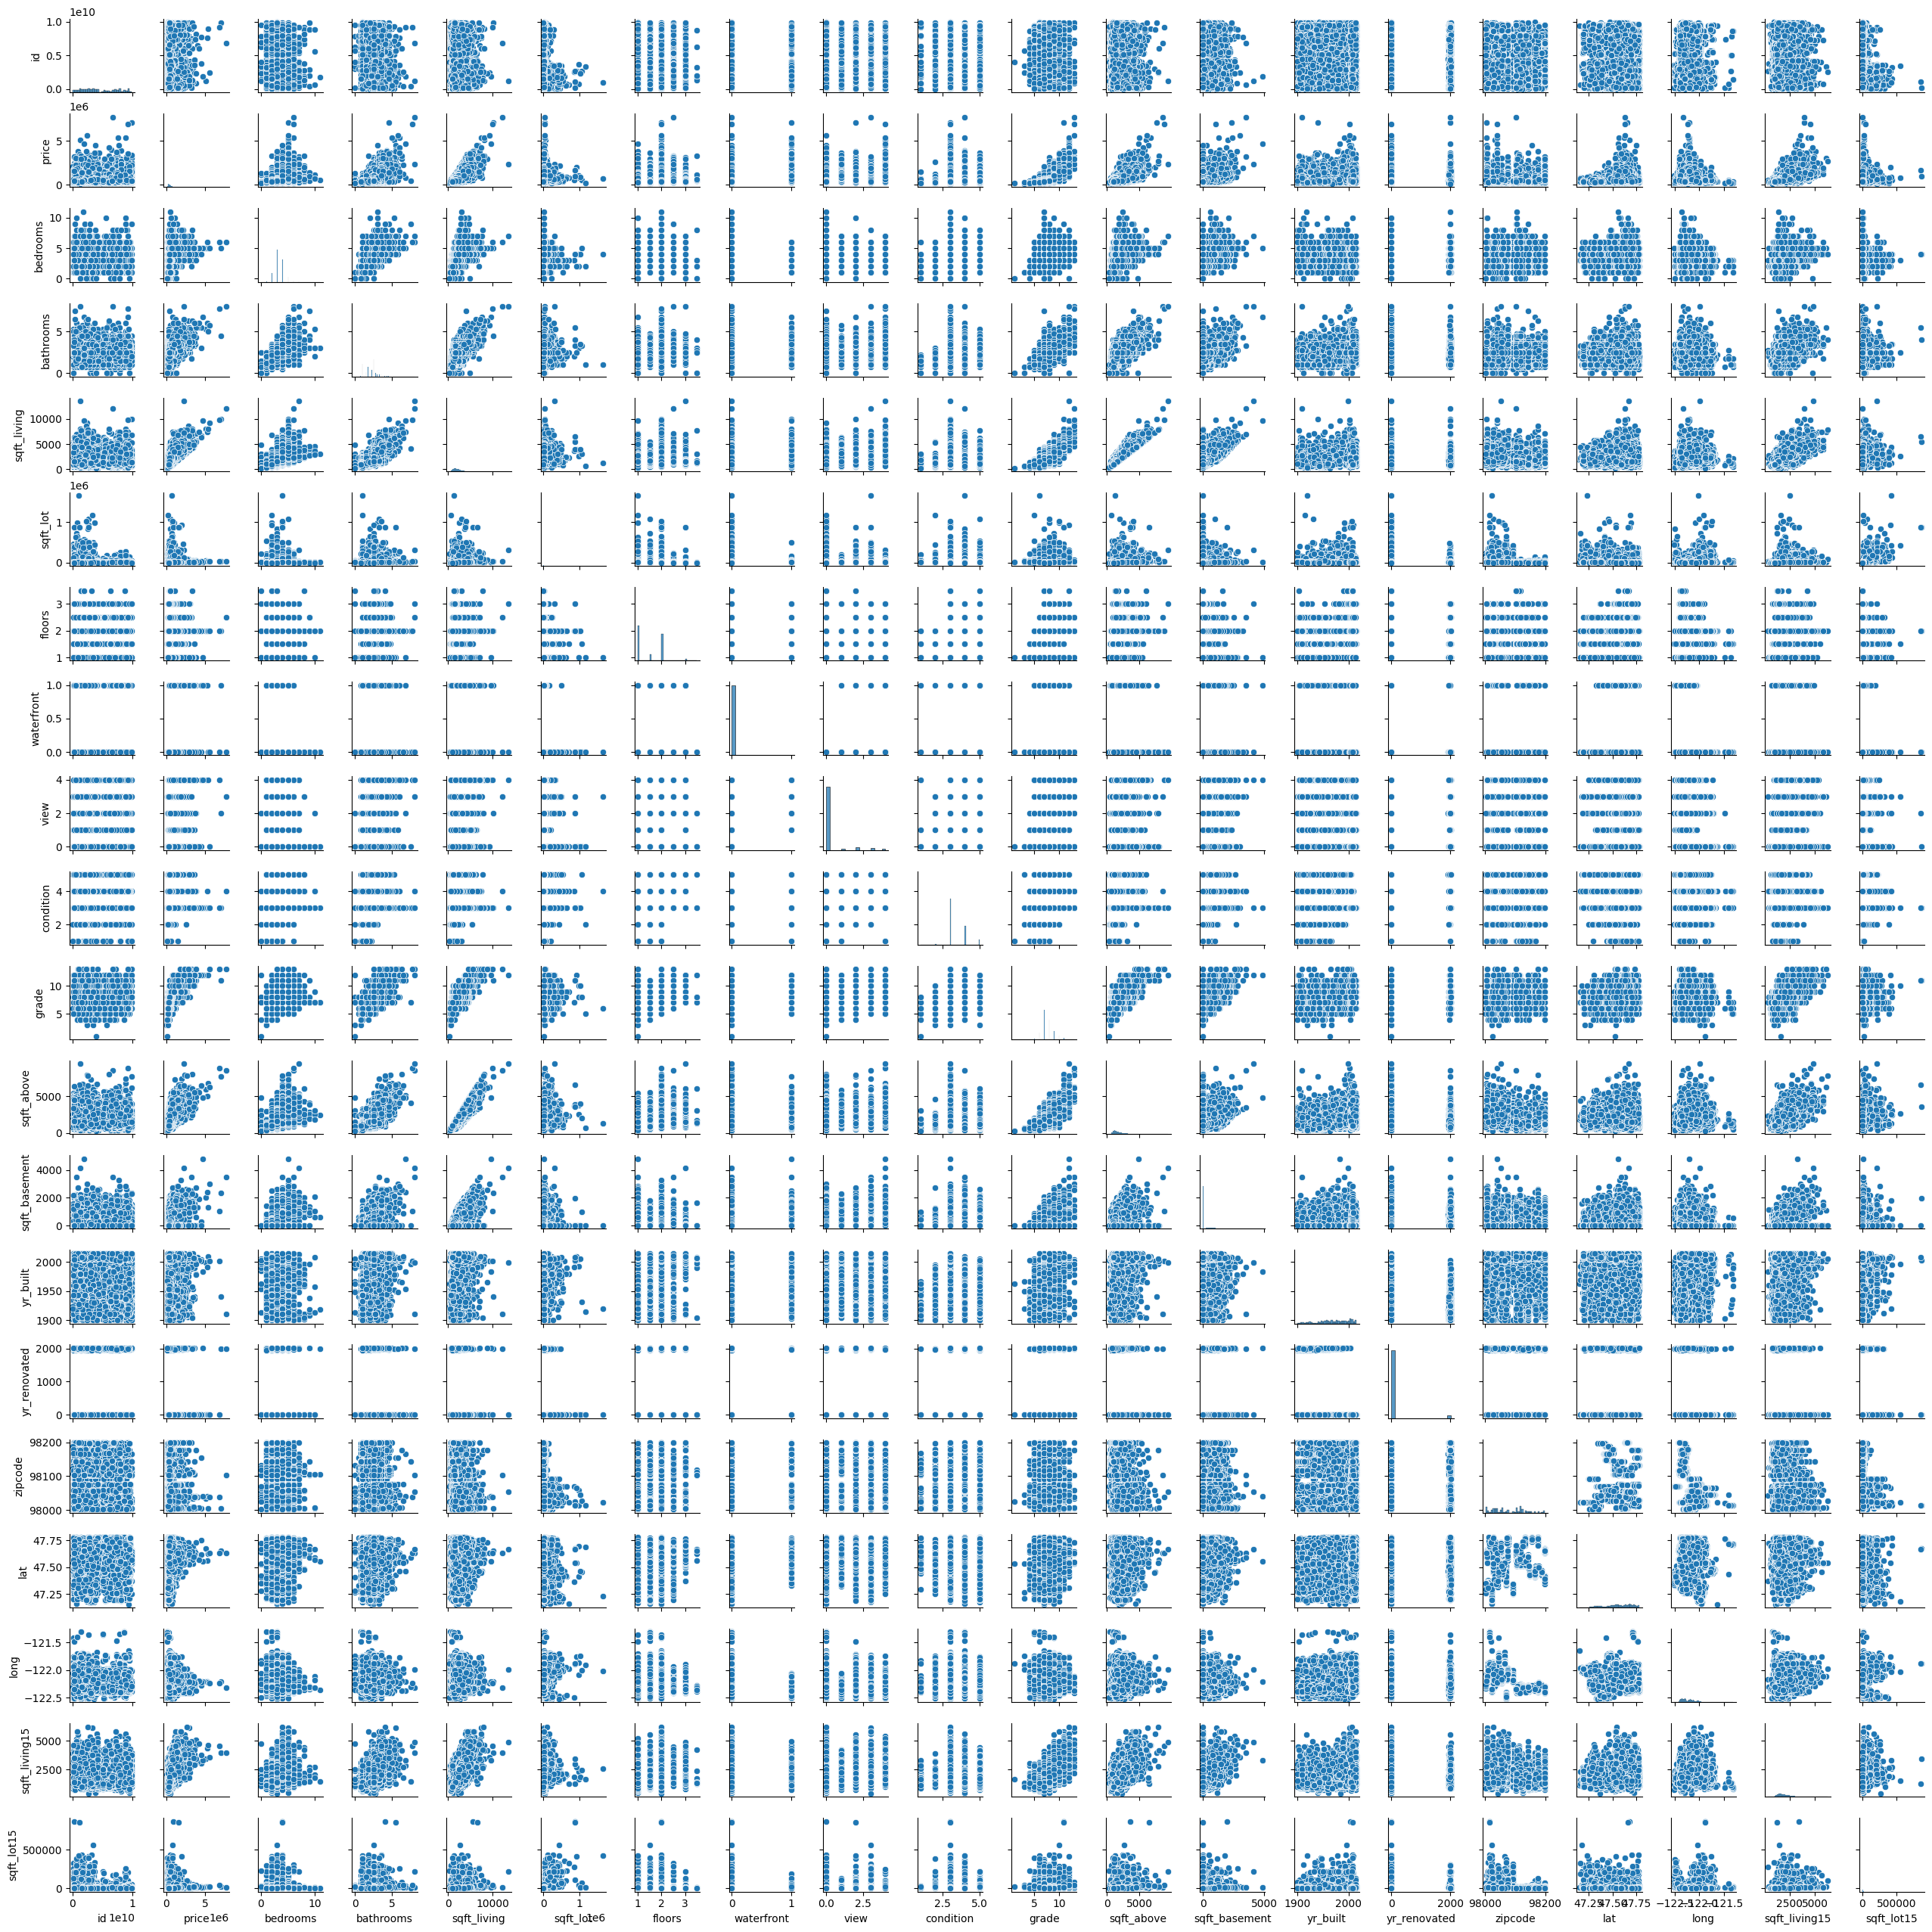

In [ ]:
sns.pairplot(df, size=1.3)

## Тепловая карта по матрице корреляции

Корреляция указывает на степень взаимосвязи между двумя переменными. Она помогает понять, как одна переменная изменяется по отношению к другой. Значение варьируется от -1 до 1, где:

*   1 указывает на полную положительную корреляцию;
*   -1 указывает на полную отрицательную корреляцию;
*   0 указывает на отсутствие корреляции.

<Axes: >

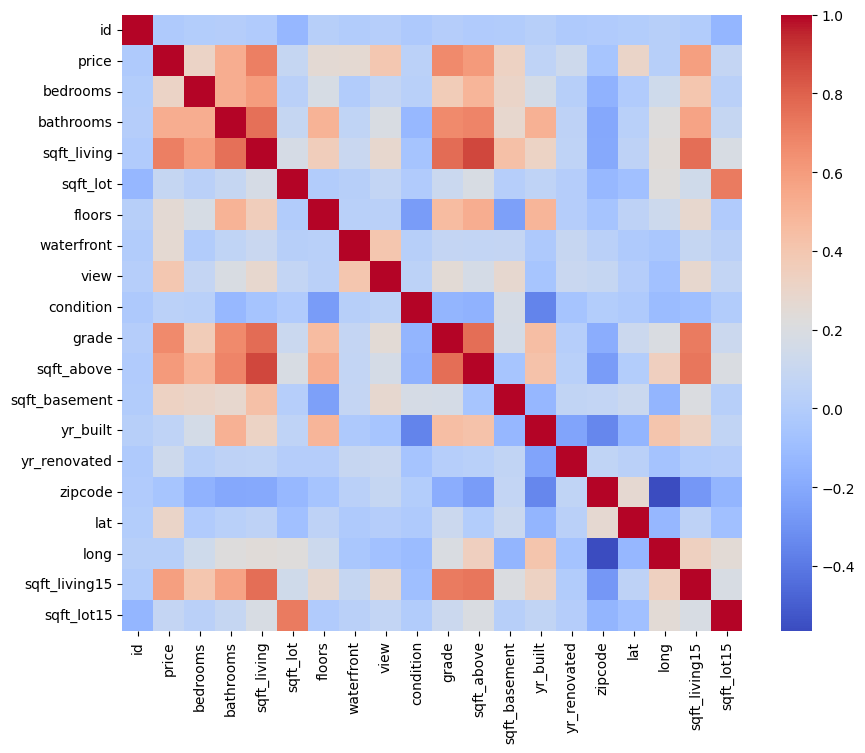

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')

## Гистограммы распределения и диаграммы размаха

Левая колонка графиков показывает гистограммы распределения для каждой характеристики. Они отображают, как часто встречаются различные значения каждой характеристики в наборе данных.

Правая колонка графиков показывает диаграммы размаха, которые визуализируют связь между каждой характеристикой и ценой недвижимости.

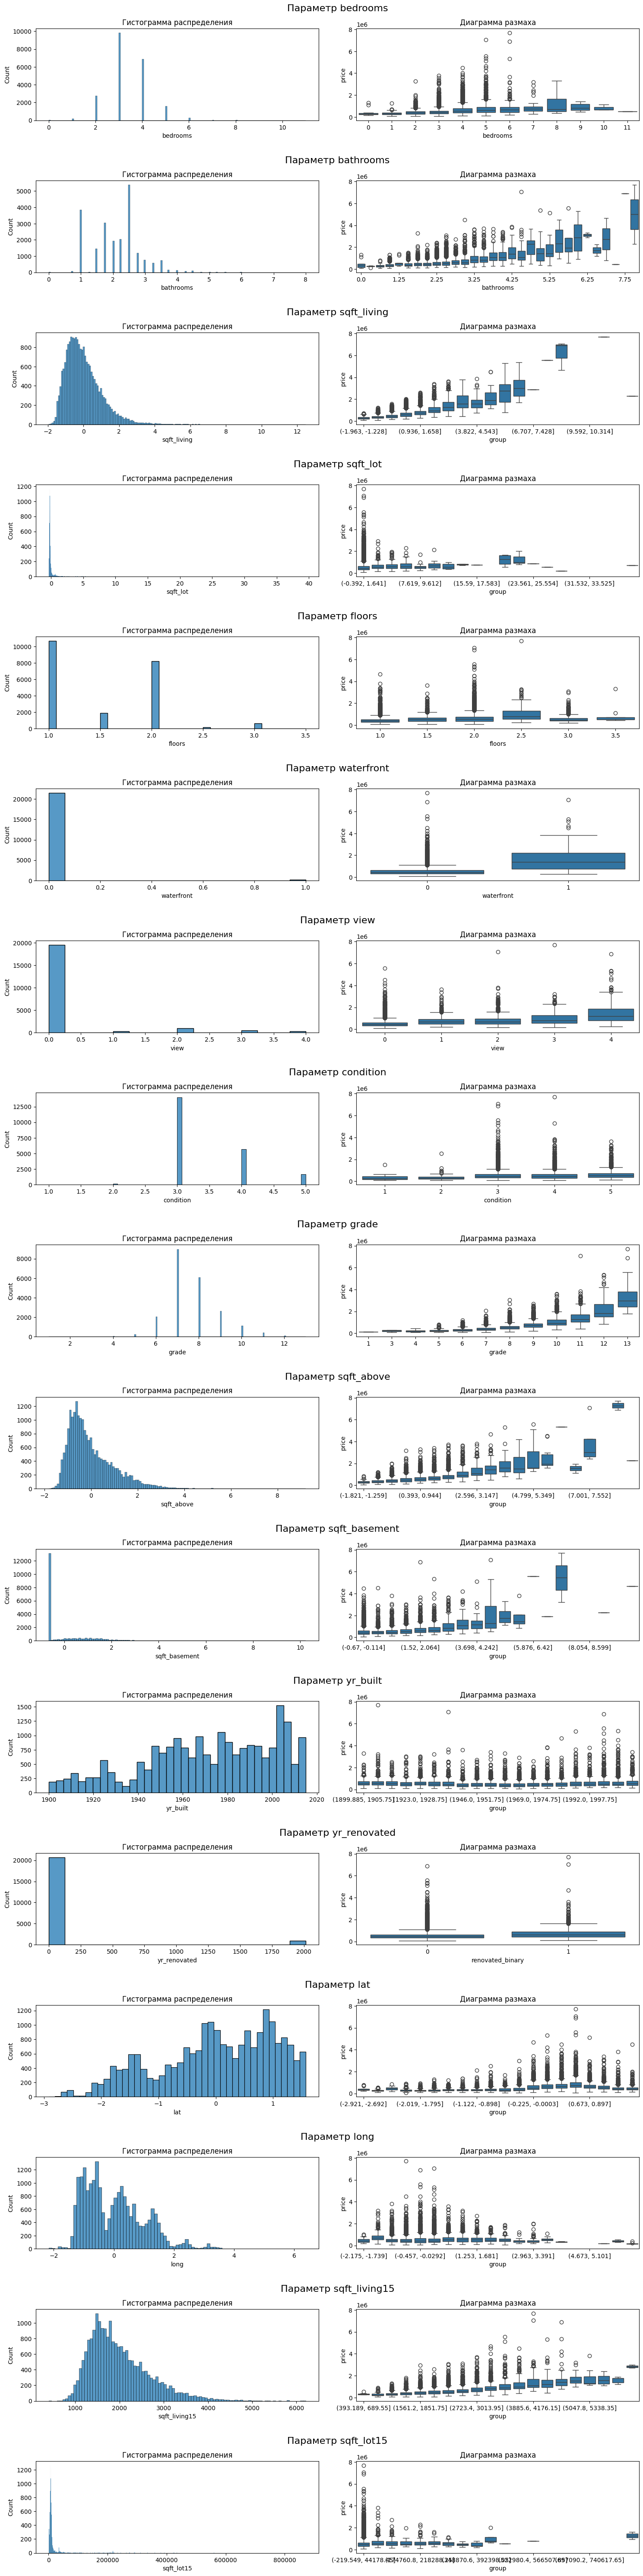

In [ ]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
        'sqft_living15', 'sqft_lot15']

fig, axes = plt.subplots(len(features), 2, figsize=(15, 80))

for i, feature in enumerate(features):
    # Создаем подграфик для каждой пары
    subfig = fig.add_subplot(len(features), 1, i+1)
    subfig.set_title(f'Параметр {feature}', fontsize=16, y=1.15)
    subfig.axis('off')  # Отключаем оси для подграфика

    # Гистограмма
    sns.histplot(df[feature], ax=axes[i, 0])

    # Диаграмма размаха
    if feature in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
               'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']:
        # Площадь делим на промежутки для наглядности
        df['group'] = pd.cut(df[feature], bins=20)
        sns.boxplot(df, x='group', y='price', ax=axes[i, 1])

    elif feature == 'yr_renovated':
        # Создаем бинарный признак для renovated
        df['renovated_binary'] = (df['yr_renovated'] > 0).astype(int)
        sns.boxplot(df, x='renovated_binary', y='price', ax=axes[i, 1])

    else:
        sns.boxplot(df, x=feature, y='price', ax=axes[i, 1])

    # Ограничение числа подписей для диаграммы размаха
    x_ticks = axes[i, 1].get_xticks()
    if len(x_ticks) >= 20: axes[i, 1].set_xticks(x_ticks[::4])

plt.tight_layout()
plt.show()

## Точечный 3D график распределения признаков

Показывает распределение цен на недвижимость в зависимости от географического расположения домов.

In [ ]:
fig = px.scatter_3d(df, x='lat', y='long', z='price', color='price',
                    title='3D распределение цен в зависимости от расположения дома')
fig.show()

## Вывод

На основе проведенного анализа можно сделать следующие выводы:

*   Площадь жилых помещений (sqft_living) имеет сильную положительную корреляцию с ценой;
*   Качество строительства (grade) также значительно влияет на стоимость дома;
*   Количество спален и ванных комнат в целом положительно коррелирует с ценой, но эта связь не линейна;
*   Расположение дома (lat, long) играет важную роль в формировании цены;
*   Дома с видом на воду (waterfront) обычно стоят дороже;
*   Более новые дома и недавно отремонтированные, как правило, имеют более высокую стоимость.

# Преобразование и нормализация данных

Объединим значения по периодам в признаках даты постройки и даты последнего капитального ремонта.

In [ ]:
def get_period(year):
  if year < 1950:
      return 'До 1950'
  elif 1950 <= year < 1980:
      return '1950-1979'
  elif 1980 <= year < 2000:
      return '1980-1999'
  else:
      return 'После 2000'

df['build_period'] = df['yr_built'].apply(get_period)
df['renovated_period'] = df['yr_renovated'].apply(lambda x: get_period(x) if x != 0 else 'Не ремонтировался')

# Нормализация числовых данных
numeric_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

df.head()

# Обучение

Подготовка данных для обучения:

In [ ]:
# Присваиваем переменные с признаками и целевую переменную
X, y = df[features], df['price']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение моделей:

In [ ]:
# Игнорирование предупреждений
warnings.filterwarnings("ignore")

# Словарь с моделями
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=1.0),
    "Ridge Regression": Ridge(alpha=1.0),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

results = []

for name, model in models.items():
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Расчет метрик
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Сохранение результатов
    results.append({
        "Model": name,
        "R-squared": r2,
        "MAE": mae,
        "MSE": mse
    })

Точность обучения моделей моделей:
                   Model  R-squared            MAE           MSE
0      Linear Regression   0.695654  127641.849808  4.567829e+10
1       Lasso Regression   0.695652  127642.400272  4.567855e+10
2       Ridge Regression   0.695593  127650.978865  4.568744e+10
3  Polynomial Regression   0.780164  106856.625501  3.299442e+10


Вывод результатов обучения:

In [ ]:
# Вывод точности обучения
print("Точность обучения моделей моделей:")
print(pd.DataFrame(results))